# Cephalon Exotic Option
### Juan Diego Herrera

The code below showcases a custom model for pricing [Cephalon's exotic options in 1997](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.200.596&rep=rep1&type=pdf) as well as the implementation of the standard binomial option pricing model

In [25]:
import math 
import matplotlib.pyplot as plt

### Code for European option pricing
Uses the following:

$ u = 1/d = exp(\sigma \sqrt{h})$

$r = e^{r_cT/n}$ where $T$ is the time in the model and $n$ is the number of steps in the tree

**Note:** This code is from the previous assignment

In [26]:
def binomialEuro(CallPut, AssetP, K, T, r, vol, N, Div):
    """
    Implements the binomial option pricing model to price a European option
    Inputs:
            CallPut - True if call, False if Put
            AssetP  - Asset price today
            K       - Strike price of the option
            T       - Time until expiry of the option (years)
            r       - Risk-free interest rate
            vol     - The volatility of the stock
            N       - Number of steps in the model
            Div     - Dividend yield of asset 
    Outputs:
        Price of the price of the option
    """
    dt = T/N # h
    
    b = -1
    if CallPut:
        b = 1 

    u =  math.exp(vol * math.sqrt(dt))
    d = 1/u
    p = (math.exp((r - Div)*dt) - d) / (u-d)
    dF = math.exp(-r *dt) # Discount factor
    
    C = {}
    
    # Set up asset movements
    for m in range(0, N+1):
            St = AssetP * (u**m) * (d**(N - m))
            C[(N, m)] = max(b*(St - K), 0)
            
    # Recursive setp
    for k in range(N-1, -1, -1):
        for m in range(0,k+1):
            C[(k, m)] =  (p * C[(k+1, m+1)] + (1-p) * C[(k+1, m)]) * dF

    return C[(0,0)]

## Cephalon Modification
We've tried modifying the code for the binomial option pricing to accomodate the extra corrollaries from the Cephalon case. 

The modifications are as follows:

* We set the number of steps in the model equal to the total periods at which the stock quote would be measured.
 
 $N = 252 * T * Measure Frequency$ 
 
 In short, this equation makes each step represent $\frac{1}{3}$ of a trading day
 
 &nbsp;
 
* We then first create asset payoffs starting at $MinDepth = N - Frequency* Lookback  \space days$. And build the tree payoff up to $N$ depth.

 &nbsp;

* Then, to mimick the Asian part of the option we use a recursive algorithm to get the average sum from a leaf up to $MinDepth$. We then average this sum and rewrite the leaves of the tree to these new values

 &nbsp;
 
* Finally, we calculate the payoff for the option at any point taking into consideration that the **positive** payoff can be expressed as $min(S(t) - K, Cap- K)$, where $Cap$ is the topped off stock price for the option

 
 **Note:** The mimicking of the Asian Provision was inspired by John C. Hull's approach to value lookback options. Hull's approach requires the user to trace the path of the option in the given time-steps in order to determine its value. This version of the code, however, takes an average of the paths in the binomial tree. As such **this implementation falls short** in valuing Asian provisions since it **does not take into account the probability of every path occuring**. A better approach to incorporate the Asian provision would've been to use a Monte Carlo Simulation
 


### Sum of a path

In [256]:
def getPathSums(Asset, minDepth, N):
    """
    Helper function to get the sum over a path in the tree.
    Inputs:
            Assets   - Dicitonary representation of payoff tree, from the max depth (N) to the minDepthe
            minDepth - Smallest possible depth
            N        - The number of steps in the tree
    Outputs: 
        A dictionary whose entries represent path sums
    """
    Sums = {}
    
    # Set up initial keys and values
    for m in range(minDepth +1):
        Sums[(minDepth, m)] = [Asset[minDepth, m], 1]

    # Start DP
    for nodeDepth in range(minDepth, N):
        for m in range(0, nodeDepth+1):
            values = Sums[(nodeDepth, m)][0]
            paths = Sums[(nodeDepth, m)][1]
            
            # Entry on the dictionary hasn't been generated yet
            if (nodeDepth+1, m) not in Sums:
                Sums[(nodeDepth+1, m)] = [values + Asset[nodeDepth+1, m]*paths, paths]
            else:
                Sums[(nodeDepth+1, m)][0] += (values + Asset[nodeDepth+1, m]*paths)
                Sums[(nodeDepth+1, m)][1] += paths
                
                
            # Entry on the dictionary hasn't been generated yet
            if (nodeDepth+1, m+1) not in Sums:
                Sums[(nodeDepth+1, m+1)] = [values + Asset[nodeDepth+1, m+1]*paths, paths]
            else:
                Sums[(nodeDepth+1, m+1)][0] += (values + Asset[nodeDepth+1, m+1]*paths)
                Sums[(nodeDepth+1, m+1)][1] += paths
    return Sums
                
                
                

### Code for exotic option

In [275]:
def cephalonExotic(CallPut, AssetP, K, T, r, vol, AvgFreq, LookBack, Cap, Div):
    """
    Implements the binomial option pricing model to price a European option
    Inputs:
            CallPut   - True if call, False if Put
            AssetP    - Asset price today
            K         - Strike price of the option
            T         - Time until expiry of the option (years)
            r         - Risk-free interest rate
            vol       - The volatility of the stock
            AvgFreq   - Number of times a day you'll get an average  of stock price
            LookBack  - Howm many days you'll look back for the average
            Cap       - Strike price cap
            Div       - Dividend yield of asset 
    Outputs:
        Price of the price of the option
    """
    
    N = int(252*T*AvgFreq )
    minDepth  = int(N - AvgFreq*LookBack) # depth level to start calculating asset prices
    dt = T/N # h
    
    b = -1
    if CallPut:
        b = 1 

    u =  math.exp(vol * math.sqrt(dt))
    d = 1/u
    p = (math.exp((r - Div)*dt) - d) / (u-d)
    dF = math.exp(-r *dt) # Discount factor
    
    print("u:", u)
    print("d:", d)
    print("p:", p)
    print(2-u)
    Asset = {}
    C = {}
    
    # Set up asset movements --- STOCK TREE
    for nodeDepth in range(minDepth, N+1):  # range is non-inclusive in Python
        for m in range(0, nodeDepth+1):
                St = AssetP * (u**m) * (d**(nodeDepth - m))
                Asset[(nodeDepth, m)] = St

                
    # Get the Average        --- ASIAN BEHAVIOR
    if LookBack != 0:
        Sums = getPathSums(Asset, minDepth, N)
        for m in range(0, N+1):
            Asset[(N,m)] = Sums[(N,m)][0]/(Sums[(N,m)][1]*(AvgFreq*LookBack + 1))
            
    # Convert to option Payout taking into account the cap
    for m in range(0, N+1):
        C[N,m] = max(min(b*(Asset[(N,m)] - K), b*(Cap - K)) , 0)
                
    # Recursive setp
    for k in range(N-1, -1, -1):
        for m in range(0,k+1):
            C[(k, m)] =  (p * C[(k+1, m+1)] + (1-p) * C[(k+1, m)]) * dF
    return C[(0,0)]

## Results
We start our evaluation by comparing the output of our custom model to that of Binomial model which clearly has converged to the Black-Scholes value 

In [255]:
exotic = cephalonExotic(1, 20, 21.5, 0.5, 0.055, 0.75, 3, 20, 39.5, 0)
euro = binomialEuro(1, 20, 21.5, 0.5, 0.055, 0.75, 126, 0)
print("Custom Model: "+ str(exotic))
print("Binomial Model: " + str(euro)) # 126 steps for fair comparison
print("Difference: " + str(round(euro-exotic,2)))

Custom Model: 3.1708241567259003
Binomial Model: 3.838056467220286
Difference: 0.67


There's a 67c difference between prices. We can try to see how much the Asian behavior costs in this scenario

In [254]:
exoticWithAvg = cephalonExotic(1, 20, 21.5, 0.5, 0.055, 0.75, 3, 20, 39.5, 0)
exoticWithoutAvg = cephalonExotic(1, 20, 21.5, 0.5, 0.055, 0.75, 1, 0, 39.5, 0)
print("Asian Provision: "+ str(exoticWithAvg))
print("Non-Asian Provision: " + str(exoticWithoutAvg) )
print("Difference: " + str(round(exoticWithoutAvg-exoticWithAvg,3)))

Asian Provision: 3.1708241567259003
Non-Asian Provision: 3.0852578033054083
Difference: -0.086


In [276]:
print("Option price Non-Asian Provision: ", 
       round(cephalonExotic(1, 20, 21.5, 0.5, 0.055, 0.75, 3, 20, 39.5, 0),3))

u: 1.0276526658761749
d: 0.9730914278779219
p: 0.494514550643718
0.9723473341238251
Option price Non-Asian Provision:  3.171


### Effect of Cap on price

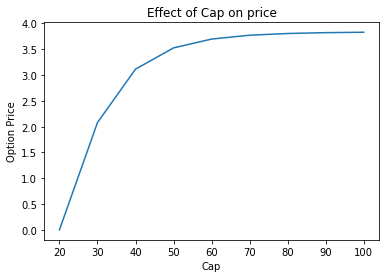

In [257]:
x = []
y = []
for i in range(20, 110, 10):
    y.append(cephalonExotic(1, 20, 21.5, 0.5, 0.055, 0.75, 1, 0, i, 0))
    x.append(i)
plt.title('Effect of Cap on price')
plt.xlabel('Cap')
plt.ylabel('Option Price')
plt.plot(x,y)
plt.show()

Note how the model converges to a standard binomial model if the cap increases

### Effect of Cap and Lookback (for averaging)

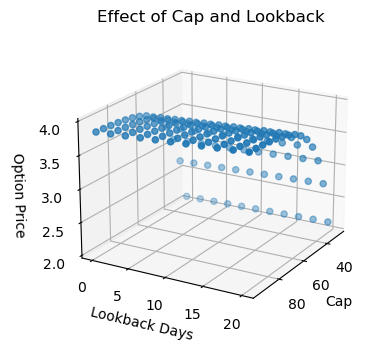

In [245]:
x = []
y = []
z = []
for i in range(30, 100, 5):
    for j in range(20,-1,-2):
        z.append(cephalonExotic(1, 20, 21.5, 0.5, 0.055, 0.75, 3, j, i, 0))
        x.append(i)
        y.append(j)
fig = plt.figure(dpi=100)
ax = plt.axes(projection='3d')
ax.set_title('Effect of Cap and Lookback')
ax.scatter(x, y, z)
ax.set_zlim3d(2,4)
ax.set_xlabel('Cap')
ax.set_ylabel('Lookback Days')
ax.set_zlabel('Option Price');
ax.view_init(20, 30)

We note thet this model is not too sensitive to the lookback period. This is probabaly due to the fact that we're simply trying to create an intuitive reflection of the Asian behavior of the option by modifying the step size - which in reality is barely modifying the model as a whole once we have a high amount of steps. The averaging also provides a rather small difference in this custom model because due to the probability scaling.

A more intuitive way to think about the behavior of the code is the following:

Since the average of the stock price only effects the deepest region of the tree (which is already quite deep - at least of depth 252), the probability scaling causes effect of the averaging to fade away by the time we reach the root. **More importantly, the code does not regard (nor weigh) the unique probabilties of reaching each path**